In [2]:
import gzip
import pandas as pd
import requests
from io import BytesIO

def load_data_from_github(url):
    response = requests.get(url)
    compressed_file = BytesIO(response.content)
    with gzip.open(compressed_file, 'rt') as file:
        data = pd.read_csv(file, sep='\t', header=None)
    return data

url = 'https://raw.githubusercontent.com/laiguokun/multivariate-time-series-data/master/electricity/electricity.txt.gz'
data = load_data_from_github(url)

url2 = 'https://raw.githubusercontent.com/laiguokun/multivariate-time-series-data/master/exchange_rate/exchange_rate.txt.gz'
data2 = load_data_from_github(url2)

url3 = 'https://raw.githubusercontent.com/laiguokun/multivariate-time-series-data/master/traffic/traffic.txt.gz'
data3 = load_data_from_github(url3)

url4 = 'https://raw.githubusercontent.com/laiguokun/multivariate-time-series-data/master/solar-energy/solar_AL.txt.gz'
data4= load_data_from_github(url4)

In [3]:
print("Data 1:")
print(data.head())
print(data.shape)
print(data.dtypes)



Data 1:
                                                   0
0  14.000000,69.000000,234.000000,415.000000,215....
1  18.000000,92.000000,312.000000,556.000000,292....
2  21.000000,96.000000,312.000000,560.000000,272....
3  20.000000,92.000000,312.000000,443.000000,213....
4  22.000000,91.000000,312.000000,346.000000,190....
(26304, 1)
0    object
dtype: object


In [4]:

# Set display options
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)        # Adjust display width to show all columns
pd.set_option('display.max_colwidth', None) # Display full content of each cell

# Display the first few rows of the dataset
print(data.head())

In [5]:
# Split the single column into multiple columns using comma as separator
data = data[0].str.split(',', expand=True)

# Convert the columns to numeric data types
data = data.apply(pd.to_numeric, errors='coerce')

# Display the first few rows of the dataset
print(data.head())

# Display the shape of the dataset
print("Shape of the dataset:", data.shape)

# Display the column names and data types
print("Columns and data types:")
print(data.dtypes)




    0     1      2      3      4       5     6       7      8      9      10   \
0  14.0  69.0  234.0  415.0  215.0  1056.0  29.0   840.0  226.0  265.0  179.0   
1  18.0  92.0  312.0  556.0  292.0  1363.0  29.0  1102.0  271.0  340.0  235.0   
2  21.0  96.0  312.0  560.0  272.0  1240.0  29.0  1025.0  270.0  300.0  221.0   
3  20.0  92.0  312.0  443.0  213.0   845.0  24.0   833.0  179.0  211.0  170.0   
4  22.0  91.0  312.0  346.0  190.0   647.0  16.0   733.0  186.0  179.0  142.0   

     11     12     13     14      15    16     17     18     19    20   \
0  148.0  112.0  171.0  229.0  1001.0  49.0  162.0  594.0   88.0  34.0   
1  192.0  143.0  213.0  301.0  1223.0  64.0  216.0  758.0  126.0  39.0   
2  171.0  132.0  185.0  261.0  1172.0  61.0  197.0  736.0  115.0  38.0   
3  149.0  116.0  151.0  209.0   813.0  40.0  173.0  661.0   93.0  21.0   
4  170.0   99.0  136.0  148.0   688.0  29.0  144.0  619.0   86.0  20.0   

      21     22     23     24     25     26     27     28    29     

In [6]:
import numpy as np

# Assuming your dataset is already defined as test1

# Convert your dataset to a NumPy array
data_array = np.array(data)

# Print the shape of your dataset
print(data_array.shape)

(26304, 321)


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# Splitting the dataset
X = data_array[:, :-1]  # Input features
y = data_array[:, -1]   # Target variable

# Splitting into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Printing the shapes of the split datasets
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nTest set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Training set shapes:
X_train: (21043, 320)
y_train: (21043,)

Test set shapes:
X_test: (5261, 320)
y_test: (5261,)


In [8]:
def rotation(x):
    flip = np.random.choice([-1, 1], size=(x.shape[0],))
    return flip[:, np.newaxis] * x


import random
def permutation(x, max_segments=5, seg_mode="equal"):
    orig_steps = np.arange(x.shape[1])

    num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))

    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            if seg_mode == "random":
                split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
                split_points.sort()
                splits = np.split(orig_steps, split_points)
            else:
                splits = np.array_split(orig_steps, num_segs[i])
            shuffled_splits = random.sample(splits, len(splits))
            warp = np.concatenate(shuffled_splits).ravel()
            ret[i, :len(warp)] = pat[warp]
        else:
            ret[i] = pat
    return ret


def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2))
    warp_steps = np.linspace(0, x.shape[1]-1., num=knot+2)
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = CubicSpline(warp_steps, random_warps[i])(orig_steps)
        ret[i] = pat * warper

    return ret


def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2))
    warp_steps = np.linspace(0, x.shape[1]-1., num=knot+2)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        time_warp = CubicSpline(warp_steps, warp_steps * random_warps[i])(orig_steps)
        scale = (x.shape[1]-1)/time_warp[-1]
        ret[i] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat).T
    return ret

def window_slice(x, reduce_ratio=0.9):
    target_len = np.ceil(reduce_ratio * x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1] - target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)

    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        ret[i] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i]]).T
    return ret

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio * x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)

    window_starts = np.random.randint(low=1, high=x.shape[1] - warp_size - 1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)

    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        start_seg = pat[:window_starts[i]]
        window_seg = np.interp(np.linspace(0, warp_size - 1, num=int(warp_size * warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i]])
        end_seg = pat[window_ends[i]:]
        warped = np.concatenate((start_seg, window_seg, end_seg))
        ret[i] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1] - 1., num=warped.size), warped).T
    return ret



In [9]:
import numpy as np
from tqdm import tqdm

# Assuming your dataset is already defined as test1

# Convert your dataset to a NumPy array
data_array = np.array(data)

# Define the jitter function
def jitter(x, sigma=0.03):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

# Define the scaling function for 2-dimensional dataset
def scaling(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],))
    return np.multiply(x, factor[:, np.newaxis])


In [10]:
import numpy as np

def interleave_time_series(data):
    new_data = []
    for i in range(len(data) - 1):
        current_point = data[i]
        next_point = data[i + 1]
        
        # Append current_point to new_data
        new_data.append(current_point)

        # Calculate and append the average of current_point and next_point to new_data
        average_point = (current_point + next_point) / 2
        new_data.append(average_point)
        
    # Add the last data point to the new_data
    new_data.append(data[-1])
    
    return np.array(new_data)

In [11]:
import numpy as np
np.random.seed(42)

def upsample_time_series_dataset(dataset, n, m):
    assert m < n, "m should be less than n"
    
    upsampled_dataset = []
    
    for series in dataset:
        # Select m consecutive points randomly
        start_index = np.random.randint(0, len(series) - m)
        selected_points = series[start_index : start_index + m]

        # Interpolate missing points
        r = n - m
        interpolated_points = np.interp(
            np.linspace(0, m - 1, n), 
            np.arange(m), 
            selected_points
        )

        upsampled_dataset.append(interpolated_points)

    return np.array(upsampled_dataset)


In [12]:
# Define the interpolate_time_series_augmentation function
def interpolate_time_series_augmentation(T, RandomIndexing, R):
    # Function implementation goes here
    n = len(T)
    L = n // R  # Length of synthetic time series
    T_hat = np.zeros(L)
    
    X = np.arange(1, n + 1)
    X_star = np.linspace(1, n, num=L * R - R + 1)
    Interpolator = np.interp(X_star, X, T)
    T_star = Interpolator
    
    
    
    for i in range(L):
        K = np.random.randint(1, R)
        if not RandomIndexing:
            T_hat[i] = T_star[i * R + K - 1]
        else:
            K_star = np.random.randint(1, R)
            T_hat[i] = T_star[i * R + K_star - 1]

    return T_hat

# Apply interpolation to each row in the training set
interpolated_data = []
for row in X_train:
    interpolated_row = interpolate_time_series_augmentation(row, True, 2)
    interpolated_data.append(interpolated_row)

# Convert the list of interpolated rows back to a numpy array
interpolated_data_array = np.array(interpolated_data)



In [13]:
# Apply the jitter function to your dataset
jittered_data = jitter(X_train)

# Apply the scaling function to your dataset
scaled_data = scaling(X_train)

# Apply the jitter function to your dataset
rotated_data = rotation(X_train)

# Apply the scaling function to your dataset
permuted_data = permutation(X_train, max_segments=5, seg_mode="equal")

# Apply the jitter function to your dataset
magnwarped_data = magnitude_warp(X_train)

# Apply the scaling function to your dataset
timewarped_data = time_warp(X_train)


# Apply the jitter function to your dataset
windowssliced_data = window_slice(X_train)

# Apply the scaling function to your dataset
windowwarped_data = window_warp(X_train)

interleaved_data = interleave_time_series(X_train)

# Apply the jitter function to your dataset
# spaener_data = spawner_without_labels(data_array)

# #Apply the scaling function to your dataset
# wdba_data = wdba(data_array)

# # Apply the jitter function to your dataset
# random_guided_warp_data = random_guided_warp(data_array)

# # Apply the scaling function to your dataset
# discriminative_guided_warp_data = discriminative_guided_warp(data_array)

In [14]:
upsampled_data=upsample_time_series_dataset(X_train,200,40)


In [15]:
# Print the first 5 rows of the original dataset
print("Original dataset:")
print(X_train[:5])

# Print the first 5 rows of the jittered dataset
print("\nJittered dataset:")
print(jittered_data[:5])

# Print the first 5 rows of the scaled dataset
print("\nScaled dataset:")
print(scaled_data[:5])

# Print the first 5 rows of the rotated dataset
print("\nRotated dataset:")
print(rotated_data[:5])

print("\nPermuted dataset:")
print(permuted_data[:5])


print("\nMagn waroed dataset:")
print(magnwarped_data[:5])

print("\nTime waroed dataset:")
print(timewarped_data[:5])

print("\nWindow Slice dataset:")
print(windowssliced_data[:5])

print("\nWindow warp dataset:")
print(windowwarped_data[:5])

print("\nInterleaved dataset:")
print(interleaved_data[:5])




Original dataset:
[[6.700e+01 8.000e+01 8.000e+00 ... 1.040e+02 3.007e+03 6.660e+02]
 [2.000e+00 1.190e+02 8.000e+00 ... 2.100e+01 1.833e+03 2.000e+02]
 [9.000e+00 1.180e+02 8.000e+00 ... 3.600e+01 2.643e+03 5.070e+02]
 [6.800e+01 1.180e+02 8.000e+00 ... 1.340e+02 3.214e+03 6.860e+02]
 [1.400e+01 1.300e+02 8.000e+00 ... 1.600e+01 1.548e+03 5.800e+02]]

Jittered dataset:
[[6.70149014e+01 7.99958521e+01 8.01943066e+00 ... 1.03990692e+02
  3.00700972e+03 6.65996096e+02]
 [2.00290988e+00 1.19017855e+02 7.97545338e+00 ... 2.10021995e+01
  1.83296130e+03 1.99961148e+02]
 [8.98992646e+00 1.18050071e+02 7.99221226e+00 ... 3.60137026e+01
  2.64301709e+03 5.07013431e+02]
 [6.80192817e+01 1.18039875e+02 8.00589564e+00 ... 1.34011800e+02
  3.21400576e+03 6.85990727e+02]
 [1.40040062e+01 1.29995426e+02 8.02124326e+00 ... 1.60617249e+01
  1.54800062e+03 5.79978160e+02]]

Scaled dataset:
[[5.96270454e+01 7.11964722e+01 7.11964722e+00 ... 9.25554138e+01
  2.67609740e+03 5.92710631e+02]
 [2.26831512e+0

In [16]:
print("\nUpsampled dataset:")
print(upsampled_data[:1])

print("\nInterpolated dataset:")
print(interpolated_data[:1])


Upsampled dataset:
[[ 409.          373.33165829  337.66331658  301.99497487  266.32663317
   230.65829146  211.34673367  193.90452261  176.46231156  159.0201005
   141.57788945  149.52763819  164.03015075  178.53266332  193.03517588
   207.53768844  213.49246231  215.64824121  217.8040201   219.95979899
   222.11557789  203.58291457  170.65829146  137.73366834  104.80904523
    71.88442211   60.44221106   71.61306533   82.7839196    93.95477387
   105.12562814  108.90954774  100.87437186   92.83919598   84.8040201
    76.76884422   83.2160804   126.52763819  169.83919598  213.15075377
   256.46231156  301.74371859  356.03015075  410.31658291  464.60301508
   518.88944724  561.64321608  466.00502513  370.36683417  274.72864322
   179.09045226   83.45226131  123.77386935  167.67336683  211.57286432
   255.47236181  299.3718593   287.40201005  267.2160804   247.03015075
   226.84422111  206.65829146  185.71859296  164.55276382  143.38693467
   122.22110553  101.05527638  587.73869347 13

In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# List of your dataset DataFrame names
dataset_names = ['X_train', 'jittered_data', 'scaled_data', 'rotated_data', 'permuted_data', 'magnwarped_data',
                 'timewarped_data', 'windowssliced_data', 'windowwarped_data', 'interleaved_data', 'upsampled_data',
                 'interpolated_data']

# Define the range of values for p and q
p_values = range(0, 40)  # Adjust the range as per your requirement
q_values = range(0, 50)  # Adjust the range as per your requirement

# Iterate over the dataset names
for dataset_name in dataset_names:
    # Get the current dataset DataFrame
    data = globals()[dataset_name]

    # Find the best (p, q) parameters for the current dataset
    best_aic = np.inf
    best_order = None

    for p in p_values:
        for q in q_values:
            try:
                # Fit the ARIMA model
                model = sm.tsa.ARIMA(data, order=(p, 0, q))
                result = model.fit()

                # Check if the current model has a lower AIC value
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, 0, q)
            except:
                continue

    # Print the best (p, q) parameters for the current dataset
    print(f"Best (p, d, q) for {dataset_name}: {best_order}")


Best (p, d, q) for X_train: None
Best (p, d, q) for jittered_data: None
Best (p, d, q) for scaled_data: None
Best (p, d, q) for rotated_data: None
Best (p, d, q) for permuted_data: None
Best (p, d, q) for magnwarped_data: None
Best (p, d, q) for timewarped_data: None
Best (p, d, q) for windowssliced_data: None
Best (p, d, q) for windowwarped_data: None
Best (p, d, q) for interleaved_data: None
Best (p, d, q) for upsampled_data: None
Best (p, d, q) for interpolated_data: None


In [18]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

def check_stationarity(dataset_names):
    for dataset_name in dataset_names:
        # Get the current dataset array
        data = globals()[dataset_name]

        # Select the first column of the array
        column_data = data[:, 0]

        # Perform the ADF test
        result = adfuller(column_data)

        # Extract the p-value from the test result
        p_value = result[1]

        # Check if the series is stationary based on the p-value
        if p_value < 0.05:
            print(f"The time series '{dataset_name}' is stationary.")
        else:
            print(f"The time series '{dataset_name}' is non-stationary.")

# List of your dataset names
dataset_names = ['X_train', 'jittered_data', 'scaled_data', 'rotated_data', 'permuted_data', 'magnwarped_data',
                 'timewarped_data', 'windowssliced_data', 'windowwarped_data', 'interleaved_data', 'upsampled_data',
                 'interpolated_data']

# Call the function to check stationarity
check_stationarity(dataset_names)


The time series 'X_train' is stationary.
The time series 'jittered_data' is stationary.
The time series 'scaled_data' is stationary.
The time series 'rotated_data' is stationary.
The time series 'permuted_data' is stationary.
The time series 'magnwarped_data' is stationary.
The time series 'timewarped_data' is stationary.
The time series 'windowssliced_data' is stationary.
The time series 'windowwarped_data' is stationary.
The time series 'interleaved_data' is stationary.
The time series 'upsampled_data' is stationary.


TypeError: list indices must be integers or slices, not tuple

In [23]:
import numpy as np
import statsmodels.api as sm

# List of your dataset array names
dataset_names = ['X_train', 'jittered_data', 'scaled_data', 'rotated_data', 'permuted_data', 'magnwarped_data',
                 'timewarped_data', 'windowssliced_data', 'windowwarped_data', 'interleaved_data', 'upsampled_data',
                 'interpolated_data']

# Define the range of values for p and q
p_values = range(0, 50)  # Adjust the range as per your requirement
q_values = range(0, 50)  # Adjust the range as per your requirement

# Iterate over the dataset names
for dataset_name in dataset_names:
    # Get the current dataset array
    data = locals()[dataset_name]

    # Select the first column of the array
    column_data = data[:, 0]

    # Find the best (p, q) parameters for the current dataset
    best_aic = np.inf
    best_order = None

    for p in p_values:
        for q in q_values:
            try:
                # Fit the ARMA model
                model = sm.tsa.ARMA(column_data, order=(p, q))
                result = model.fit()

                # Check if the current model has a lower AIC value
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, q)
            except:
                continue

    # Print the best (p, q) parameters for the current dataset
    print(f"Best (p, q) for {dataset_name}: {best_order}")


Best (p, q) for X_train: None
Best (p, q) for jittered_data: None
Best (p, q) for scaled_data: None
Best (p, q) for rotated_data: None
Best (p, q) for permuted_data: None
Best (p, q) for magnwarped_data: None
Best (p, q) for timewarped_data: None
Best (p, q) for windowssliced_data: None
Best (p, q) for windowwarped_data: None
Best (p, q) for interleaved_data: None
Best (p, q) for upsampled_data: None


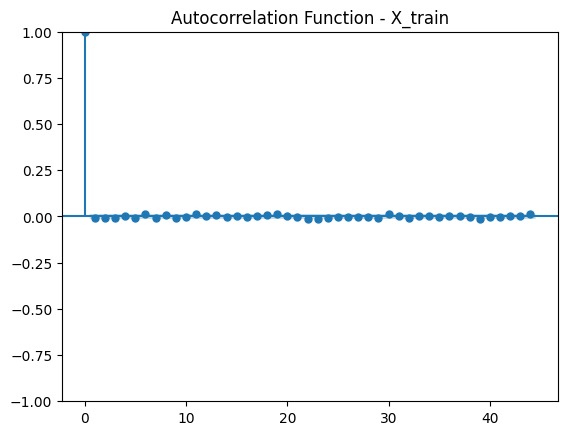

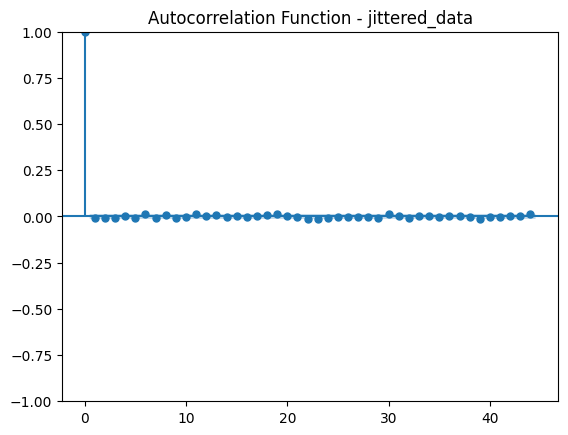

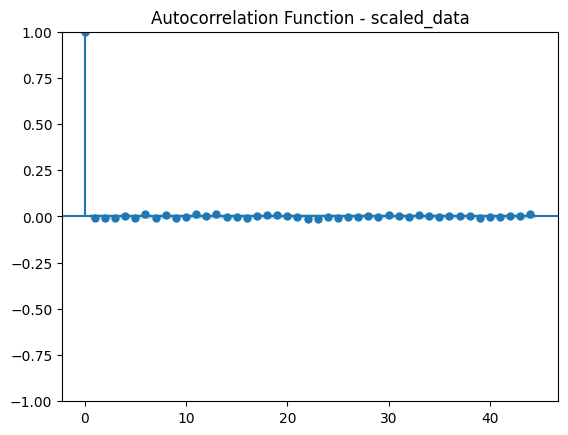

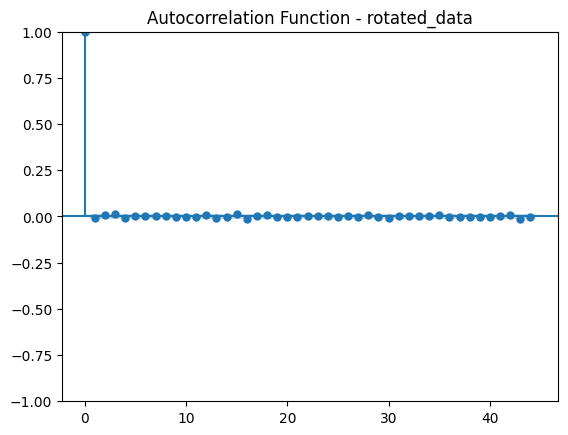

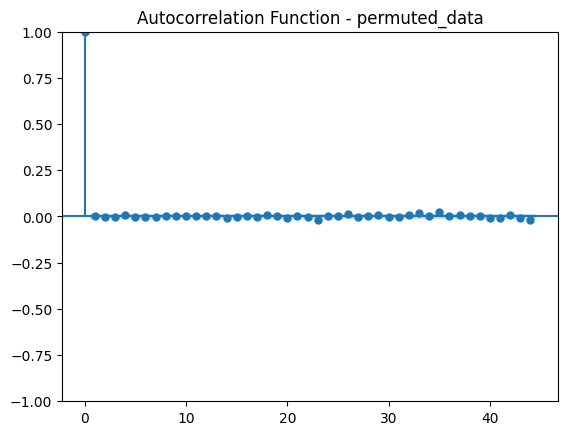

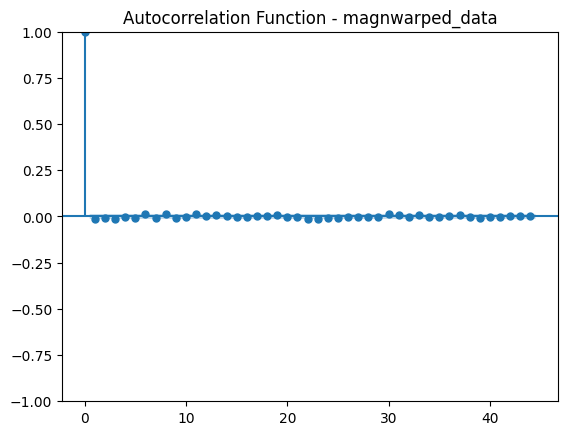

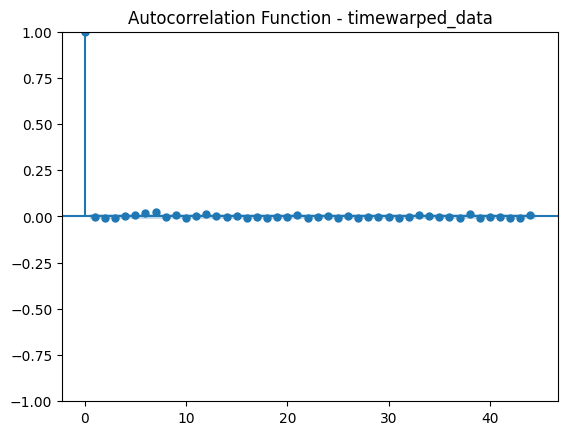

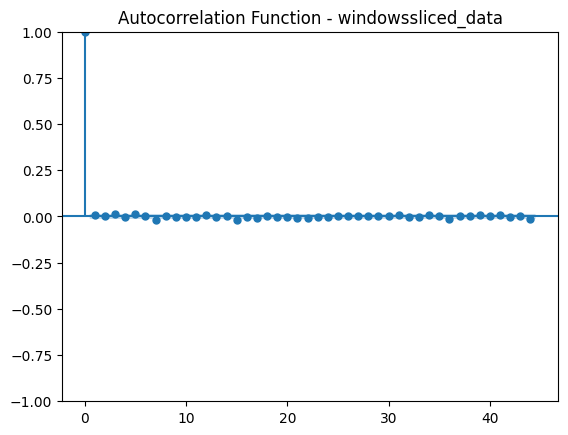

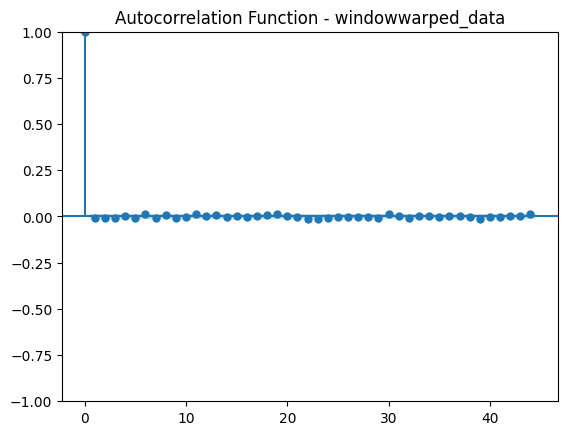

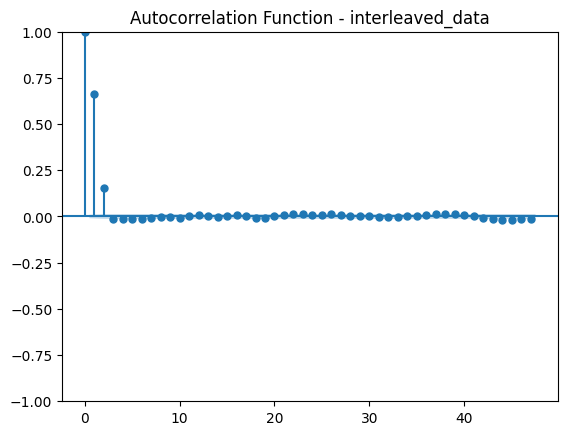

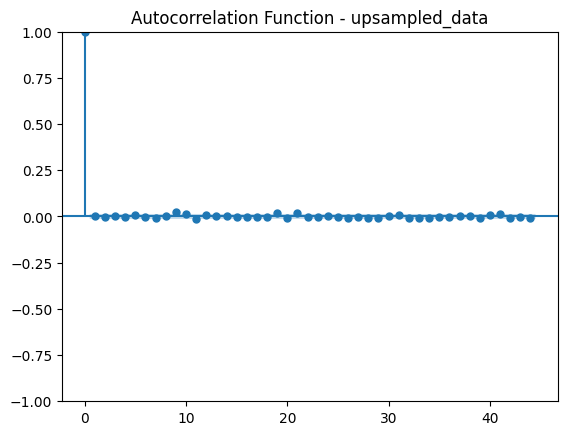

TypeError: list indices must be integers or slices, not tuple

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# List of your dataset names
dataset_names = ['X_train', 'jittered_data', 'scaled_data', 'rotated_data', 'permuted_data', 'magnwarped_data',
                 'timewarped_data', 'windowssliced_data', 'windowwarped_data', 'interleaved_data', 'upsampled_data',
                 'interpolated_data']

# Iterate over the dataset names
for dataset_name in dataset_names:
    # Get the current dataset array
    data = globals()[dataset_name]

    # Select the first column of the array
    column_data = data[:, 0]

    # Plot the autocorrelation function
    plot_acf(column_data)
    plt.title(f"Autocorrelation Function - {dataset_name}")
    plt.show()


In [31]:
import numpy as np

# List of your dataset DataFrame names
dataset_names = ['X_train', 'jittered_data', 'scaled_data', 'rotated_data', 'permuted_data', 'magnwarped_data',
                 'timewarped_data', 'windowssliced_data', 'windowwarped_data', 'interleaved_data', 'upsampled_data']

# Iterate over the dataset names
for dataset_name in dataset_names:
    # Get the current dataset DataFrame
    data = globals()[dataset_name]

    # Calculate correlation matrix
    correlation_matrix = np.abs(np.corrcoef(data.T))

    # Exclude self-correlation values (diagonal) and calculate the average
    correlation_values = correlation_matrix[np.triu_indices(correlation_matrix.shape[0], k=1)]
    average_correlation = np.mean(correlation_values)

    # Print the average correlation coefficient
    print(f"Average correlation coefficient for {dataset_name}: {average_correlation}")


Average correlation coefficient for X_train: 0.4885966601153595
Average correlation coefficient for jittered_data: 0.4885965030054311
Average correlation coefficient for scaled_data: 0.5154397707939881
Average correlation coefficient for rotated_data: 0.8979048365774981
Average correlation coefficient for permuted_data: 0.23842671923388203
Average correlation coefficient for magnwarped_data: 0.4039302747102864
Average correlation coefficient for timewarped_data: 0.026057462156153545
Average correlation coefficient for windowssliced_data: 0.12444285244322317
Average correlation coefficient for windowwarped_data: 0.16595241537354172
Average correlation coefficient for interleaved_data: 0.4885922119948567
Average correlation coefficient for upsampled_data: 0.08066472439809194


In [37]:
import statsmodels.api as sm

# List of your dataset names
dataset_names = ['X_train', 'jittered_data', 'scaled_data', 'rotated_data', 'permuted_data', 'magnwarped_data',
                 'timewarped_data', 'windowssliced_data', 'windowwarped_data', 'interleaved_data', 'upsampled_data']

# Iterate over the dataset names
for dataset_name in dataset_names:
    # Get the current dataset array
    data = globals()[dataset_name]

    # Select the target variable column
    target_variable = data[:, 0]  # Adjust the column index as per your dataset

    # Fit the ARIMA model
    model = sm.tsa.ARIMA(target_variable, order=(0, 0, 0))  # Set d=0 for no differencing
    result = model.fit()

    # Forecast future values
    forecast = result.forecast(steps=10)  # Adjust the number of steps as per your requirement

    # Print the forecasted values
    print(f"Forecast for {dataset_name}: {forecast}")


Forecast for X_train: [23.24905432 23.24905432 23.24905432 23.24905432 23.24905432 23.24905432
 23.24905432 23.24905432 23.24905432 23.24905432]
Forecast for jittered_data: [23.24880935 23.24880935 23.24880935 23.24880935 23.24880935 23.24880935
 23.24880935 23.24880935 23.24880935 23.24880935]
Forecast for scaled_data: [23.24750595 23.24750595 23.24750595 23.24750595 23.24750595 23.24750595
 23.24750595 23.24750595 23.24750595 23.24750595]
Forecast for rotated_data: [-0.29231111 -0.29231111 -0.29231111 -0.29231111 -0.29231111 -0.29231111
 -0.29231111 -0.29231111 -0.29231111 -0.29231111]
Forecast for permuted_data: [411.35579528 411.35579528 411.35579528 411.35579528 411.35579528
 411.35579528 411.35579528 411.35579528 411.35579528 411.35579528]
Forecast for magnwarped_data: [23.27140797 23.27140797 23.27140797 23.27140797 23.27140797 23.27140797
 23.27140797 23.27140797 23.27140797 23.27140797]
Forecast for timewarped_data: [102.71167219 102.71167219 102.71167219 102.71167219 102.7116

In [16]:
# sarima_forecasts = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/SARIMA_FORECASTS.csv')
sarima_forecasts = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/SARIMA_FORECASTS_Updated.csv')
sarima_forecasts.shape

(376, 2)

In [17]:
sarima_forecasts = sarima_forecasts[["h1"]]


In [18]:
orig = data.iloc[44:-1]
orig.shape

(26259, 321)

In [19]:
quater = pd.DataFrame((orig.values.squeeze() + half.values.squeeze())/2)


NameError: name 'half' is not defined

In [ ]:
print(data.shape)
print(sarima_forecasts.shape)

(26304, 321)
(376, 1)


In [20]:
reshaped_sarima_forecasts = np.tile(sarima_forecasts.values, (70, 1))  # Repeat the values 70 times to match the number of rows in data


In [21]:
print(data.shape)
print(sarima_forecasts.shape)

(26304, 321)
(376, 1)


In [22]:
print(data.shape)
print(reshaped_sarima_forecasts.shape)


(26304, 321)
(26320, 1)


In [23]:
reshaped_sarima_forecasts = reshaped_sarima_forecasts[:26259].reshape(-1)  # Reshape to (26259,)
half = pd.DataFrame((data.iloc[44:26259+44].values.reshape(-1, 321) + reshaped_sarima_forecasts.reshape(-1, 1)) / 2)


In [24]:
quater = pd.DataFrame((orig.values.squeeze() + half.values.squeeze())/2)


In [25]:
reshaped_sarima_forecasts = reshaped_sarima_forecasts.reshape(-1, 1)


In [26]:
third_quarter = pd.DataFrame((half.values.squeeze() + reshaped_sarima_forecasts) / 2)


In [27]:
augmented_ts = np.arange(2*half.shape[0]).tolist()
for i in range(0,half.shape[0]):
    augmented_ts[2*i] = orig.iloc[i][0]
    augmented_ts[2*i+1] = half.iloc[i][0]

In [28]:
len(augmented_ts)
augmented_ts = np.array(augmented_ts)
augmented_ts = np.reshape(augmented_ts,(-1,2))
augmented_ts = np.reshape(augmented_ts,(-1,1))
augmented_ts.shape

(52518, 1)

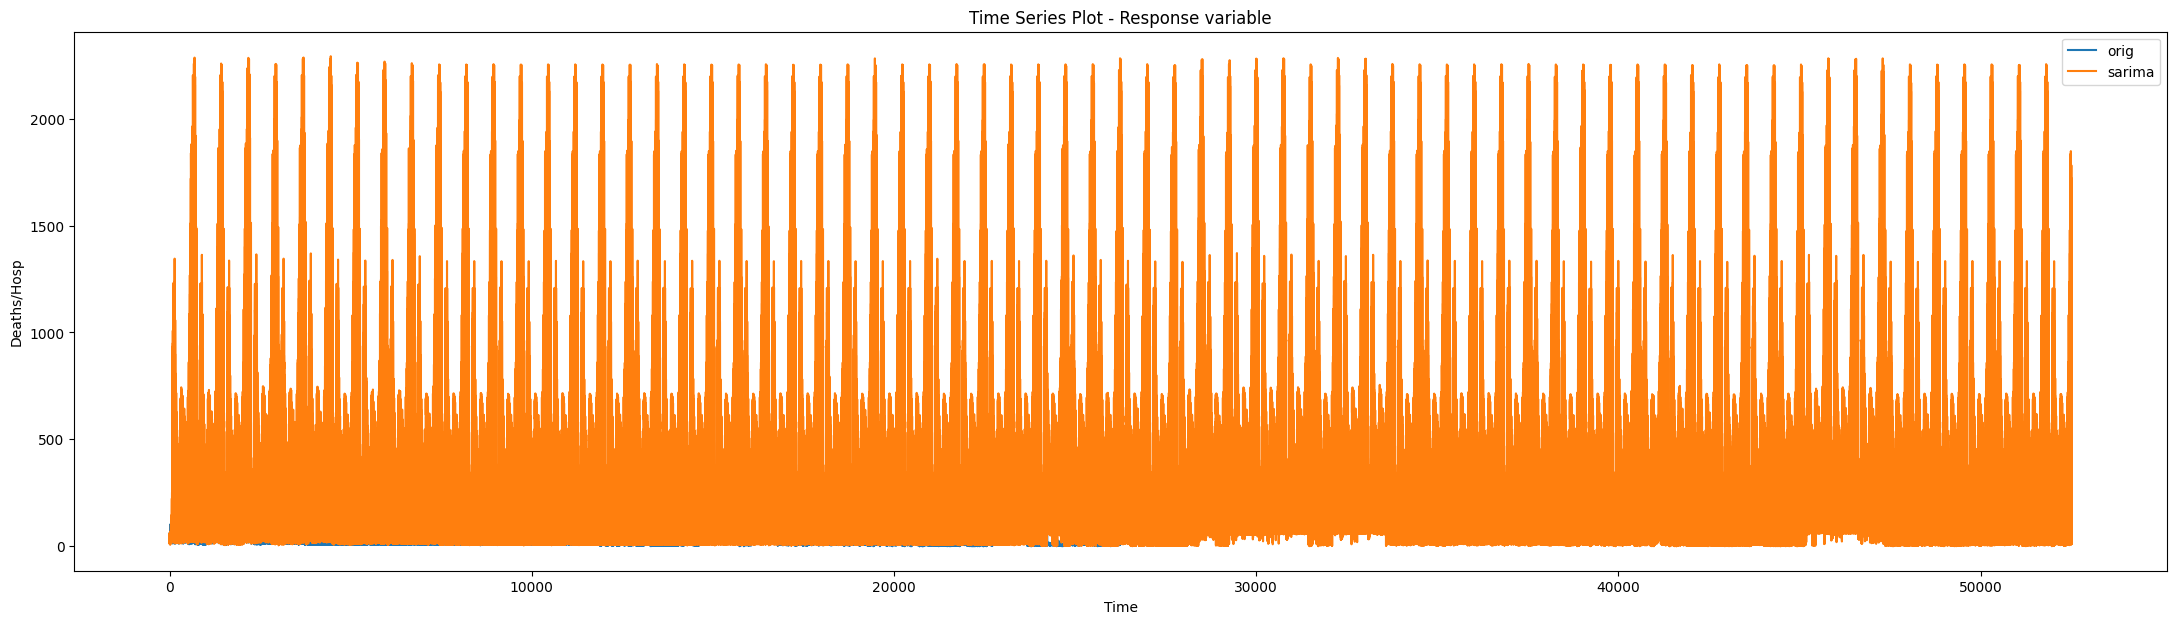

In [29]:
import matplotlib.pyplot as plt

elim_samples = 43
lags = 21
horizons = 14
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# scaler.fit(augmented_ts)
sc = MinMaxScaler(feature_range = (-1, 1))

# augmented_ts = sc.fit_transform(augmented_ts)   #Scaling 
# augmented_ts = scaler.transform(augmented_ts)     #Standarizing 

plt.figure(num=0, figsize=(27,7),dpi=100)
plt.plot(data.iloc[elim_samples+1:,0].values.squeeze())
plt.plot(augmented_ts)
plt.legend(['orig','sarima'])
plt.xlabel('Time')
plt.ylabel('Deaths/Hosp')
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,101))
# plt.yticks(np.arange(0, 101, 10.0))
plt.title("Time Series Plot - Response variable")
plt.show()
# print(scaler.mean_, scaler.var_)

In [30]:
#Generate lagged Y to use as input matrix(X) and future lagged Y as output matrix(Y) for the NeuralNet
def ts2IF(ts, s, h):
    m = ts.shape[0] - s - h + 1
    x = pd.DataFrame(np.random.randint(10, size=(m, s)))
    y = pd.DataFrame(np.random.randint(10, size=(m, h)))
    for i in range(m):
        for j in range(x.shape[1]): x.iloc[i, j] = ts[i + j]
        for j in range(y.shape[1]): y.iloc[i, j] = ts[i + j + s]
    #x['ones'] = np.ones(x.shape[0])                        # add first column of all ones
    x.columns = ["lag"+str(x) if(x!=0) else "origY" for x in range(1,s+1)]
#     x.insert(0,"ones",np.ones(x.shape[0]).astype(int),True)                # add first column of all ones
    return (x, y)


In [31]:
lagX, lagY = ts2IF(data.iloc[elim_samples+1:,0].values.squeeze(),lags,horizons)
# lagX, lagY = ts2IF(np.array(augmented_ts),lags,horizons)


X = pd.DataFrame(lagX)
X.columns = lagX.columns
feat = X.shape[1]
print(X.shape)

(26226, 21)


In [32]:
time = [float(x) for x in range(1,X.shape[0]+1)]
X['time'] = time
X

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,time
0,28,62,18,57,18,18,17,16,15,15,14,14,67,68,66,69,71,56,33,70,102,1.0
1,62,18,57,18,18,17,16,15,15,14,14,67,68,66,69,71,56,33,70,102,23,2.0
2,18,57,18,18,17,16,15,15,14,14,67,68,66,69,71,56,33,70,102,23,67,3.0
3,57,18,18,17,16,15,15,14,14,67,68,66,69,71,56,33,70,102,23,67,47,4.0
4,18,18,17,16,15,15,14,14,67,68,66,69,71,56,33,70,102,23,67,47,29,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26221,7,7,7,7,5,6,17,15,12,12,13,12,14,13,13,14,13,13,13,13,13,26222.0
26222,7,7,7,5,6,17,15,12,12,13,12,14,13,13,14,13,13,13,13,13,13,26223.0
26223,7,7,5,6,17,15,12,12,13,12,14,13,13,14,13,13,13,13,13,13,13,26224.0
26224,7,5,6,17,15,12,12,13,12,14,13,13,14,13,13,13,13,13,13,13,10,26225.0


In [33]:
from sklearn.preprocessing import minmax_scale, scale
def rescale(inp,act_func='tanh'):
    if(act_func=='tanh'): return  minmax_scale(inp,feature_range=(-1,1))
    if(act_func=='sigmoid'): return  minmax_scale(inp,feature_range=(0,1))
    if(act_func=='linear' or act_func=='elu'): return  inp
    else: return inp


In [34]:
Y = pd.DataFrame(rescale(lagY,"linear"))
print(Y.shape)
Y.head()

(26226, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,23,67,47,29,74,56,56,20,24,22,20,22,17,20
1,67,47,29,74,56,56,20,24,22,20,22,17,20,18
2,47,29,74,56,56,20,24,22,20,22,17,20,18,61
3,29,74,56,56,20,24,22,20,22,17,20,18,61,70
4,74,56,56,20,24,22,20,22,17,20,18,61,70,90


In [41]:
%%time
nz = (lags+1) * 5 + 2
feat = X.shape[1]

l1 = X.columns.tolist()
l2 = ['numerical' for x in l1]
col_typ = dict(zip(l1,l2))

elim_samples = 43
lags = 42
horizons = 28
# lagX, lagY = ts2IF(dat.iloc[elim_samples+1:,0].values.squeeze(),lags,horizons)
lagX, lagY = ts2IF(np.array(augmented_ts),lags,horizons)


X = pd.DataFrame(rescale(lagX,"elu"))
X.columns = lagX.columns

time = [float(x) for x in range(1,X.shape[0]+1)]
X['time'] = time

feat = X.shape[1]
print(X.shape)

Y = pd.DataFrame(rescale(lagY,"linear"))
print(Y.shape)


def rollingValidate(model,x,y,kt,horizons,callbk,nEpoch,nBatch,plot,p1=False,p2=False,shuffle=True,aug=True,train=True):
    TR_RATIO = 0.588
    m = y.shape[0]
    tr_size = int(m * TR_RATIO)
    te_size = int(m - tr_size)
    te = int(tr_size)
    if kt < 0: kt = te_size
    print("m = "+str(m)+", tr_size = "+str(tr_size)+", te_size = "+str(te_size)+", kt = "+str(kt)+", horizons = "+str(horizons))
    
    (x_e, y_e, x_r, y_r) = chopr (x, y, te, te_size, tr_size)
#     x_r = x_r[1000:]
#     y_r = y_r[1000:]
    print("Training shape"+str(x_r.shape))
    print("Training shape"+str(y_r.shape))
    print("Testing shape"+str(x_e.shape))
    print("Testing shape"+str(y_e.shape))
    smapearr = [x for x in range(10,(10+horizons))]
    for h in range(1,horizons+1):
#         print(type(y_r))
        yr =  y_r[h-1]
        inp = y_e[h-1].values.tolist()
        yrw = inp[:-h]
        for i in range(h):
            yrw.insert(i,inp[i])
        yrw = np.array(yrw)
        rSqr, maper, smaper, mser, rmser, sser, sstr = eval(y_e[h-1],yrw)
        smapearr[h-1] = smaper

    rt = 0
#     print("number of re-trainings required = "+str(int((te_size/kt)+1)))
    for i in range(y_e.shape[0]):
        if i%kt == 0:
            rt = rt + 1
            if i > 0:
                x_r, y_r = shift_rm((x_r,y_r),((x_e.iloc[i-kt:i], y_e.iloc[i-kt:i])))
            if train:
#                 print("training set: "+str(x_r.shape))
                if callbk==1:
                    callb = callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=20,verbose=1)
                else: callb = None   #batch_input_shape=(10, 5, 1)
#                 fit_history = model.fit(x_r, y_r,validation_split=0.0,shuffle=True,epochs=nEpoch, \
#                                         batch_input_shape=(64, 44, 1),verbose=0, callbacks=callb) #callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,show_epoch_progress=False)]  workers=10, use_multiprocessing=True,
                fit_history = model.fit(x_r, y_r,validation_split=0.0,shuffle=shuffle,epochs=nEpoch, \
                                        batch_size=nBatch,verbose=0, callbacks=callb) #callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,show_epoch_progress=False)]  workers=10, use_multiprocessing=True,
            if plot: plotHistory(fit_history)
#     print("\nOut-Sample Results")
#     rw = np.array([2.47,3.79,4.6,5.23,5.75,6.18,6.61,6.94,7.29,7.70]) #RW results - mape for 50% TR
    rw = np.array([float(x) for x in smapearr]) #calculated using python
    beats = []
    prediction = model.predict(x_e,batch_size=x_e.shape[0])
    rSq  = [x for x in range(y.shape[1])]
    mse  = [x for x in range(y.shape[1])]
    sse  = [x for x in range(y.shape[1])]
    sst  = [x for x in range(y.shape[1])]
    rmse = [x for x in range(y.shape[1])]
    mape = [x for x in range(y.shape[1])]
    smape = [x for x in range(y.shape[1])]
    maxdif = 0
    maxdifh = 0
    if aug: inc = 2
    else: inc = 1
    for h in range(inc,y.shape[1]+1,inc):
        yf = prediction[:,h-1]
        rSq[h-1], mape[h-1], smape[h-1], mse[h-1], rmse[h-1], sse[h-1], sst[h-1] = eval(y_e.values[:,h-1],yf)
        if p1:
            print(str(smape[h-1]))  #,str(rw[h-1])
#             print(str(rw[h-1]))  #,str(rw[h-1])
    return (rSq, mape, smape, mse, rmse, sse, sst, beats, prediction, y_e)

KeyboardInterrupt: 

In [40]:
%%time
import autokeras as ak
rsX = pd.DataFrame(rescale(X,"linear"))
lX = rsX.values.reshape(rsX.shape[0],rsX.shape[1],1) #(batch_size, timestep/window, no. features/lags)
lY = Y.values.reshape(Y.shape[0],Y.shape[1],1)
input_layer = ak.Input()
rnn_layer = ak.RNNBlock(layer_type="gru")(input_layer)
dense_layer = ak.DenseBlock()(rnn_layer)
output_layer = ak.RegressionHead()(dense_layer)

automodel = ak.AutoModel(input_layer, output_layer, max_trials=2, loss='mean_absolute_percentage_error',metrics='mean_absolute_percentage_error',overwrite=True,objective='val_loss', project_name='NAS')
automodel.fit(lX, Y.values, validation_split=0.4, epochs=250, batch_size=32, verbose=0)
model = automodel.export_model()
print(model.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(model,False,lX,Y,-1,horizons,callbk=1,nEpoch=1,nBatch=32,plot=False,p1=True,p2=True)


ImportError: cannot import name 'AlbertClassifier' from partially initialized module 'keras_nlp.src.models.albert.albert_classifier' (most likely due to a circular import) (/home/savvas/venvs/demo-project-venv/lib/python3.10/site-packages/keras_nlp/src/models/albert/albert_classifier.py)

In [36]:
def rollingValidate(model,x,y,kt,horizons,callbk,nEpoch,nBatch,plot,p1=False,p2=False,shuffle=True,aug=True,train=True):
    TR_RATIO = 0.588
    m = y.shape[0]
    tr_size = int(m * TR_RATIO)
    te_size = int(m - tr_size)
    te = int(tr_size)
    if kt < 0: kt = te_size
    print("m = "+str(m)+", tr_size = "+str(tr_size)+", te_size = "+str(te_size)+", kt = "+str(kt)+", horizons = "+str(horizons))
    
    (x_e, y_e, x_r, y_r) = chopr (x, y, te, te_size, tr_size)
#     x_r = x_r[1000:]
#     y_r = y_r[1000:]
    print("Training shape"+str(x_r.shape))
    print("Training shape"+str(y_r.shape))
    print("Testing shape"+str(x_e.shape))
    print("Testing shape"+str(y_e.shape))
    smapearr = [x for x in range(10,(10+horizons))]
#     for h in range(1,horizons+1):
# #         print(type(y_r))
#         yr =  y_r[h-1]
#         inp = y_e[h-1] #.values.tolist()
#         yrw = inp[:-h]
#         for i in range(h):
#             yrw.insert(i,inp[i])
#         yrw = np.array(yrw)
#         rSqr, maper, smaper, mser, rmser, sser, sstr = eval(y_e[h-1],yrw)
#         smapearr[h-1] = smaper

    rt = 0
#     print("number of re-trainings required = "+str(int((te_size/kt)+1)))
    for i in range(y_e.shape[0]):
        if i%kt == 0:
            rt = rt + 1
            if i > 0:
                x_r, y_r = shift_rm((x_r,y_r),((x_e.iloc[i-kt:i], y_e.iloc[i-kt:i])))
            if train:
#                 print("training set: "+str(x_r.shape))
                if callbk==1:
                    callb = callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=40,verbose=1)
                else: callb = None   #batch_input_shape=(10, 5, 1)
#                 fit_history = model.fit(x_r, y_r,validation_split=0.0,shuffle=True,epochs=nEpoch, \
#                                         batch_input_shape=(64, 44, 1),verbose=0, callbacks=callb) #callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,show_epoch_progress=False)]  workers=10, use_multiprocessing=True,
                fit_history = model.fit(x_r, y_r,validation_split=0.0,shuffle=shuffle,epochs=nEpoch, \
                                        batch_size=nBatch,verbose=0, callbacks=callb) #callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,show_epoch_progress=False)]  workers=10, use_multiprocessing=True,
            if plot: plotHistory(fit_history)
#     print("\nOut-Sample Results")
#     rw = np.array([2.47,3.79,4.6,5.23,5.75,6.18,6.61,6.94,7.29,7.70]) #RW results - mape for 50% TR
    rw = np.array([float(x) for x in smapearr]) #calculated using python
    beats = []
    prediction = model.predict(x_e,batch_size=x_e.shape[0])
#     print(type(prediction))
#     print(prediction.shape)
#     print(type(y_e))
#     print(y_e.shape)
#     print(y_e.columns)
    rSq  = [x for x in range(y.shape[1])]
    mse  = [x for x in range(y.shape[1])]
    sse  = [x for x in range(y.shape[1])]
    sst  = [x for x in range(y.shape[1])]
    rmse = [x for x in range(y.shape[1])]
    mape = [x for x in range(y.shape[1])]
    smape = [x for x in range(y.shape[1])]
    maxdif = 0
    maxdifh = 0
    if aug: inc = 2
    else: inc = 1
    for h in range(inc,y.shape[1]+1,inc):
        yf = prediction[:,h-1]
        rSq[h-1], mape[h-1], smape[h-1], mse[h-1], rmse[h-1], sse[h-1], sst[h-1] = eval(y_e.values[:,h-1],yf)
#         diff = (rw[h-1] - float(mape[h-1]))
#         if rw[h-1] >= float(mape[h-1]): beats.append(h)
#         if diff > maxdif:
#             maxdif = diff
#             maxdifh = h
        if p1:
            print(str(smape[h-1]))  #,str(rw[h-1])
#             if h < 10: print("h="+str(h)+"  -> "+" smape= "+str(smape[h-1])+","+str(rw[h-1]))    
#             else: print("h="+str(h)+" -> "+" smape= "+str(smape[h-1])+","+str(rw[h-1]))  
#             if h != 10: print("h="+str(h)+"  -> "+"rsq = "+str(rSq[h-1])+" mape = "+str(mape[h-1])+","+str(format(rw[h-1],'.2f'))+" mse = "+str(mse[h-1])+" rmse = "+str(rmse[h-1]) +" sst = "+str(sst[h-1])) #" sse = "+str(sse[h-1]) +
#             else: print("h="+str(h)+" -> "+"rsq = "+str(rSq[h-1])+" mape = "+str(mape[h-1])+","+str(format(rw[h-1],'.2f'))+" mse = "+str(mse[h-1])+" rmse = "+str(rmse[h-1]) +" sst = "+str(sst[h-1])) #" sse = "+str(sse[h-1]) +)
#     if p2: 
#         print("Beats RW at "+str(len(beats))+" values of h="+str(beats))
#         print("Max difference = "+str(maxdif)+" at horizon h="+str(maxdifh))
    return (rSq, mape, smape, mse, rmse, sse, sst, beats, prediction, y_e)

In [37]:
true_pred = [x for ind,x in enumerate(prediction[:,1].squeeze().tolist()) if (ind+1)%2==0]
true_data = [x for ind,x in enumerate(y_e.values.squeeze()[:,1].tolist()) if (ind+1)%2==0]
dates = range(1, len(true_data) + 1)
# ytick = np.arange(0, 5000, 500)
# xtick = np.arange(0, 133, 7)
plt.figure(num=0, figsize=(20,8))
plt.plot(dates,true_data)
plt.plot(dates,true_pred)
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
# plt.xticks(xtick)
# plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()

NameError: name 'prediction' is not defined

In [38]:
true_pred = [x for ind,x in enumerate(prediction[:,0].squeeze().tolist()) if (ind+1)%2==0]
true_data = [x for ind,x in enumerate(y_e.values.squeeze()[:,0].tolist()) if (ind+1)%2==0]
true_pred.append(prediction[-1,0])
true_data.append(y_e.values.squeeze()[-1,0])
dates = range(1, len(true_data) + 1)
print(len(dates))
# ytick = np.arange(0, 5000, 500)
# xtick = np.arange(0, 133, 7)
plt.figure(num=0, figsize=(20,8))
plt.plot(dates,true_data)
plt.plot(dates,true_pred)
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
# plt.xticks(xtick)
# plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()

NameError: name 'prediction' is not defined